# Lockdown baking - part 2

A project for scraping and analysing data from reddit (r/Sourdough) to explore baking trends during 2020.

Part 2: Data cleaning and classification

# Setup

In [1]:
## set root folder
import os 
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calplot #to make calendar heat map

%matplotlib inline

# Clean data

## Load data

In [48]:
#load scraped datafiles
df = pd.read_csv(".\\data\scraped\post_df_2021-01-07.csv")

In [17]:
# explore shape and columns
print(df.shape)
print(df.columns)
print("")
print(df.head(3))

(41309, 8)
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'can_mod_post', 'author'],
      dtype='object')

   Unnamed: 0      id  score  created_utc  \
0           0  eibhvl      1   1577839131   
1           1  eibvur      1   1577841129   
2           2  eiby7m      1   1577841483   

                                               title  num_comments  \
0  First attempt at a starter, really hope I mana...             5   
1  Skillet &amp; Dutch Oven Sourdough in the rain...             0   
2  My last bread of 2019. I used Brad and Claire’...             0   

   can_mod_post         author  
0         False  coentertainer  
1         False     Richness69  
2         False     canioli019  


## Remove unnecessary data

In [53]:
print(df["can_mod_post"].value_counts()) 

#since there are no moderators, we don't need this variable
df = df.drop(columns=["can_mod_post"])

#check if column has been removed correctly
print(df.columns)

False    41309
Name: can_mod_post, dtype: int64
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'author', 'posts_by_user', 'created', 'created_month',
       'created_month_label', 'created_short', 'created_weekday',
       'created_hour', 'created_week'],
      dtype='object')


## Clean data

### User group

In [51]:
# count number of posts by author and put them into groups
bins = [0, 1, 2, 5, 10, 50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['posts_by_user'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pivot.reset_index().drop(columns="id")

# add column to dataframe based on number of posts by author as 'user group'
df = pd.merge(df, pivot, left_on="author", right_on="author")

#print head
df.head()

,Unnamed: 0,id,score,created_utc,title,num_comments,can_mod_post,author,posts_by_user
0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,False,coentertainer,1
1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,False,Richness69,1
2,2,eiby7m,1,1577841483,My last bread of 2019. I used Brad and Claire’...,0,False,canioli019,2
3,276,ektkdp,1,1578313987,"This bread came out really nice, I just have a...",11,False,canioli019,2
4,3,eictkk,1,1577846281,I started baking in September and I have never...,0,False,singular-chip,6-10


### Derive date and time variables

In [52]:
from datetime import datetime

# derive datetime from unix timestamp
df["created"] = pd.to_datetime(df["created_utc"], unit = 's')

#derive month from datetime
df["created_month"] = pd.DatetimeIndex(df["created"]).month
df["created_month_label"] = df["created_month"].map({1: "January", 2: "February", 3:"March", 4:"April", 5:"May",
                                                    6:"June", 7:"July", 8:"August", 9:"September", 10:"October",
                                                    11:"November", 12: "December"})

#derive day from datetime
df["created_short"] = df.created.dt.strftime("%Y-%m-%d")

#derive weekday from datetime
weekday_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4: "Friday", 5:"Saturday", 6:"Sunday"}
df["created_weekday"] = pd.DatetimeIndex(df["created"]).weekday

#derive hour from datetime
df["created_hour"] = pd.DatetimeIndex(df["created"]).hour

#derive week number from datetime
df["created_week"] = pd.DatetimeIndex(df["created"]).week

<ipython-input-52-a0622d61cd99>:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["created_week"] = pd.DatetimeIndex(df["created"]).week


### Title

We need to clean the text data in the title so that we can do some proper text mining. This includes

- Standardising
- Tokenising and removing stop words
- Lemmatising





#### Standardising

We will remove punctuation and clean any other symbols/words as needed.

In [59]:
# make titles lower case
title = df["title"].str.lower()

# replace values within titles

# function to loop through the column and replace substrings
def replace_values(text, dic):
    for x, y in dic.items():
        text = text.str.replace(x, y, regex=True)
    return text

# list of values to be replaced, including punctuation
replace_dict = {"&amp;": "", #xml syntax for &
                "[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]": "",
                "pnw" : "pacific northwest",
                "  ": " ", #double space
                "’s" :"",  
                "’m" : "",
                "loaves": "loaf"
               }
                
# apply function
title = replace_values(title, replace_dict)

# strip white space at the end
title = title.str.strip()

# add new column to dataframe
df["title_standardised"] = title

print(title)

0        first attempt at a starter really hope i manag...
1        skillet dutch oven sourdough in the rainy paci...
2        my last bread of 2019 i used brad and claire r...
3        i started baking in september and i have never...
4                                          sourdough books
                               ...                        
41304                               honey walnut sourdough
41305    so happy with how my sourdough finally turned ...
41306    sourdough bbq faux chicken pizza no 🐔 were har...
41307    got my first starter last week as a christmas ...
41308               last 2020 feeding for dame judi stench
Name: title, Length: 41309, dtype: object


#### Remove stop words

We now remove stop words that don't really help to identify the sentiment or topic of a sentence. 

In [60]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [61]:
# create empty list to store titles without stop words
title_no_stop_words = []

# iterate through each word in each title and append those that are no stop words
# split titles into substrings using space as delimiter
for words in title.str.split(" "):
    x = []
    for word in words:
        if word not in stop_words:
            x.append(word)
    title_no_stop_words.append(x)

# join titles back together
title_no_stop_words = [" ".join(items) for items in title_no_stop_words]

# add title to dataframe
df["title_no_stop_words"] = title_no_stop_words

print(title_no_stop_words[:10])

['first attempt starter really hope manage keep alive mixed existence opening second decade', 'skillet dutch oven sourdough rainy pacific northwest', 'last bread 2019 used brad claire recipe alive sourdough starter smelled bit sweet weird bread turned good anyways', 'started baking september never happier decision may new year bring happy starters crackly crusts', 'sourdough books', 'analyzing sourdough', 'ginger tumeric loaf guide decade', 'behold bread majors incite rocky horror sourdough', 'last loaf year', 'wheat flour starter vs rye starter']


#### Lemmatize
Now we want to reduce the inflectional forms of each word into a common base or root. We do this by using a lemmatiser that detects the lemma for each word. 

Read [this article](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/) for more information on the difference betweent stemmatising and lemmatising. 

In [63]:
import en_core_web_sm

# load model from SpaCy
nlp = en_core_web_sm.load()

# create new list to store lemmatised titles
title_lemmatised = []

# iterate through each word in each title and append the lemmatised version of the word
for words in pd.Series(title_no_stop_words):
    x = []
    for word in nlp(words):
        x.append(word.lemma_)
    title_lemmatised.append(x)

# join titles back together
title_lemmatised = [" ".join(items) for items in title_lemmatised]

df["title_lemmatised"] = title_lemmatised

### Remove duplicates

In [69]:
# detect duplicates based on author and title standardised
print("Number of duplicate rows: ",len(df[df[["author", "title_standardised"]].duplicated(keep="last")]))

#remove duplicates and reset index
df = df.drop_duplicates(subset=["author", "title_standardised"],keep="last").reset_index(drop=True) #data ordered by date, last = latest
print("New number of rows: ", len(df))

Number of duplicate rows:  78
New number of rows:  40515


### Export cleaned dataframe

In [72]:
#load scraped datafiles
df.to_csv(".\\data\processed\df-for-analysis_2021-01-24.csv")

# Analysis

## Engagement over time

In [7]:
## Submissions and comments by month
pivot = df.groupby("created_month")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})
pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,id,num_comments,author
created_month,,,
1,1584,9289,1025
2,1629,8081,1025
3,3315,14550,2155
4,7569,31204,4740
5,7121,31009,4293
6,4575,22517,2781
7,3633,20111,2285
8,2915,13030,1848
9,2120,10083,1440


<AxesSubplot:xlabel='created_month'>

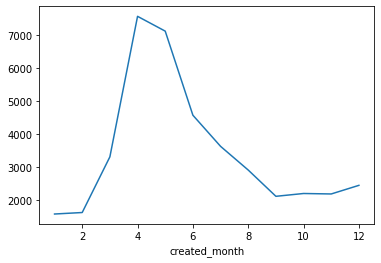

In [47]:
df.groupby("created_month")["id"].count().plot(kind='line')

<AxesSubplot:xlabel='created_month'>

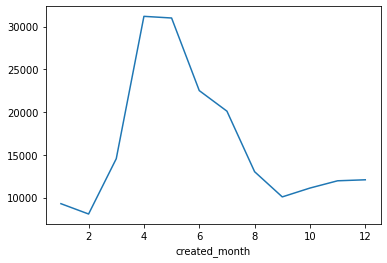

In [48]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line')

### Summary by week

In [14]:
## Submissions and comments by week
pivot = df.groupby("created_week")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})
pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,id,num_comments,author
created_week,,,
1,244,1885,207
2,389,2031,314
3,328,1860,269
4,393,2090,328
5,377,2004,322
6,382,2043,305
7,361,1842,278
8,414,1664,333
9,446,2318,354


### Summary by weekday

In [9]:
## Submissions and comments by weekday
pivot = df.groupby("created_weekday")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})

pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,id,num_comments,author
created_weekday,,,
0,6070,26750,4332
1,5460,29406,4015
2,5576,29240,4060
3,5287,26784,3881
4,5236,26930,3927
5,6262,26827,4313
6,7418,29105,4947
Total,41309,195042,16865


### summary by month

In [29]:
df2 = df[["created_month", "created_month_label", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'created_month_label': 'first',
                                                       'author': ["nunique", 'count'],
                                                       'num_comments': ['sum', 'max'] 
                                                      })
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index().rename(columns={"created_month":"month", 
                                        "nunique":"unique_user", 
                                        "count": "no_of_submissions", 
                                        "sum":"total_comments",
                                       "max": "max_comments",
                                       "first": "month_label"})

# create metrics per user
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#save output
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,month_label,unique_user,no_of_submissions,total_comments,max_comments,submission_per_user,comments_per_submission
0,1,January,1025,1584,9289,112,1.545366,5.864268
1,2,February,1025,1629,8081,63,1.589268,4.960712
2,3,March,2155,3315,14550,143,1.538283,4.389140
3,4,April,4740,7569,31204,951,1.596835,4.122605
4,5,May,4293,7121,31009,955,1.658747,4.354585
5,6,June,2781,4575,22517,619,1.645092,4.921749
6,7,July,2285,3633,20111,619,1.589934,5.535645
7,8,August,1848,2915,13030,216,1.577381,4.469983
8,9,September,1440,2120,10083,204,1.472222,4.756132
9,10,October,1474,2205,11117,199,1.495929,5.041723


## Calendar heatmap

Using [calplot](https://calplot.readthedocs.io/en/latest/). 

(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2020'>], dtype=object))

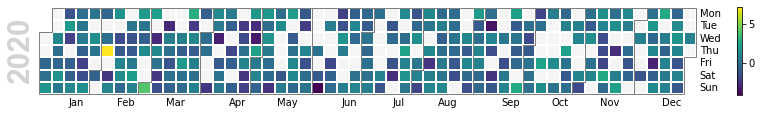

In [14]:
# example code
import calplot
import numpy as np; np.random.seed(sum(map(ord, 'calplot')))


all_days = pd.date_range('1/1/2020', periods=365, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calplot.calplot(events)

### Comments

array([<AxesSubplot:ylabel='2020'>], dtype=object)

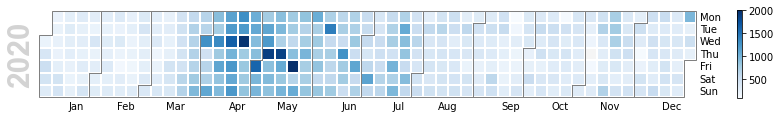

In [45]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["num_comments"].sum()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

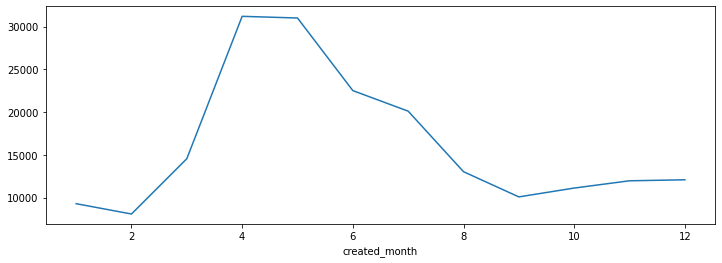

In [59]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line', figsize=(12,4))

### Posts

array([<AxesSubplot:ylabel='2020'>], dtype=object)

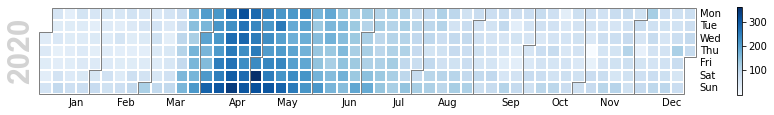

In [58]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["id"].count()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

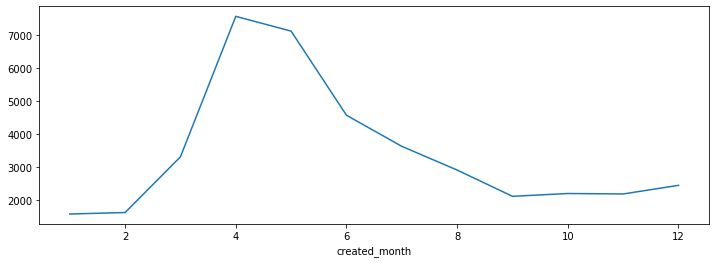

In [57]:
df.groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

## Comments

In [8]:
df["num_comments"].describe()

count    41309.000000
mean         4.721538
std         16.162486
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        955.000000
Name: num_comments, dtype: float64

In [31]:
#look at posts with highest number of comments
comments = df[["title", "created_month_label", "num_comments"]].sort_values(by="num_comments", ascending=False).head(30)

#save output
comments.to_csv(".//data/charts/top30-posts-by-comments.csv", index=False)

#display
comments

,title,created_month_label,num_comments
19225,Weekly Open Sourdough Questions and Discussion...,May,955
11884,Open Sourdough Questions and Discussion Post -...,April,951
15774,Open Sourdough Questions and Discussion Post -...,May,945
17514,Weekly Open Sourdough Questions and Discussion...,May,881
14246,Open Sourdough Questions and Discussion Post -...,May,821
26255,Weekly Open Sourdough Questions and Discussion...,July,619
22619,Weekly Open Sourdough Questions and Discussion...,June,619
9866,General /r/sourdough discussion post - April 1...,April,525
21302,Weekly Open Sourdough Questions and Discussion...,June,494
24011,Weekly Open Sourdough Questions and Discussion...,June,474


## Number of users

### overview

In [64]:
df2 = df[["created_month", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'author': [pd.Series.nunique, 'count'],
                                                                               'num_comments': ['sum']})
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index()
df2 = df2.rename(columns={"created_month":"month", "nunique":"unique_user", "count": "no_of_submissions", "sum":"total_comments"})
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#load scraped datafiles
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,unique_user,no_of_submissions,total_comments,submission_per_user,comments_per_submission
0,1,1025,1584,9289,1.545366,5.864268
1,2,1025,1629,8081,1.589268,4.960712
2,3,2155,3315,14550,1.538283,4.389140
3,4,4740,7569,31204,1.596835,4.122605
4,5,4293,7121,31009,1.658747,4.354585
5,6,2781,4575,22517,1.645092,4.921749
6,7,2285,3633,20111,1.589934,5.535645
7,8,1848,2915,13030,1.577381,4.469983
8,9,1440,2120,10083,1.472222,4.756132
9,10,1474,2205,11117,1.495929,5.041723


### number of submissions by user

On average, users submitted only 1 post, this is true for more than half of users. Two thirds have submitted at least 2 posts. On the top range, there is one user with 618 submissions which is now been deleted and 

In [9]:
pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot["id"].describe()

count    16865.000000
mean         2.449392
std          5.858573
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        618.000000
Name: id, dtype: float64

In [53]:
bins = [0, 1, 2, 5, 10 ,50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['users_by_posts'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pd.DataFrame(pivot["users_by_posts"].value_counts()).reset_index()
pivot["user_by_posts_perc"] = pivot["users_by_posts"] / pivot["users_by_posts"].sum() *100

# save output
pivot.to_csv(".\\data\charts\posts_by_user_bins.csv", index=False)

pivot

,index,users_by_posts,user_by_posts_perc
0,1,9483,56.228876
1,2,3207,19.015713
2,3-5,2833,16.798103
3,6-10,938,5.561814
4,11-50,392,2.324340
5,Over 50,12,0.071153


In [88]:
pivot = pivot.sort_values(by="id", ascending=False)
pivot.head(15)

,id
author,
[deleted],618
the_bread_code,79
Pmcdonald16,72
ruffneckred,68
cool-bird,66
Redrockcod,63
BeardBeardBabyDunDun,58
michaelcgk,58
oilologist,58


### Engagement for users over time

In [58]:
df.loc[df["posts_by_user"]== '1']

,Unnamed: 0,id,score,created_utc,title,num_comments,author,posts_by_user,created,created_month,created_month_label,created_short,created_weekday,created_hour,created_week
0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,coentertainer,1,2020-01-01 00:38:51,1,January,2020-01-01,2,0,1
1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,Richness69,1,2020-01-01 01:12:09,1,January,2020-01-01,2,1,1
12,5,eidtic,1,1577852213,Analyzing sourdough?,1,amisanyal,1,2020-01-01 04:16:53,1,January,2020-01-01,2,4,1
13,6,eidxpd,1,1577852956,Ginger tumeric loaf to guide me out of the decade,2,bleuxballs,1,2020-01-01 04:29:16,1,January,2020-01-01,2,4,1
27,10,eih45l,1,1577875456,My sourdough starter smells like vomit,7,nahnahxd,1,2020-01-01 10:44:16,1,January,2020-01-01,2,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41304,41294,knyfbd,1,1609449968,Such a sense of pride seeing it double. Winter...,4,Shoobadoo39,1,2020-12-31 21:26:08,12,December,2020-12-31,3,21,53
41305,41300,knziro,1,1609453786,Starter in LA?,5,madshills,1,2020-12-31 22:29:46,12,December,2020-12-31,3,22,53
41306,41304,ko0212,1,1609455696,Honey walnut sourdough!,0,LifeAsWeKnewIt,1,2020-12-31 23:01:36,12,December,2020-12-31,3,23,53
41307,41307,ko0m15,1,1609457690,Got my first starter last week as a Christmas ...,2,g28_x0y0z0,1,2020-12-31 23:34:50,12,December,2020-12-31,3,23,53


<AxesSubplot:xlabel='created_month'>

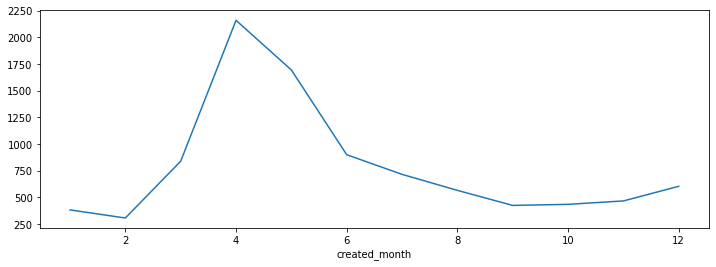

In [62]:
df.loc[df["posts_by_user"]=='1'].groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

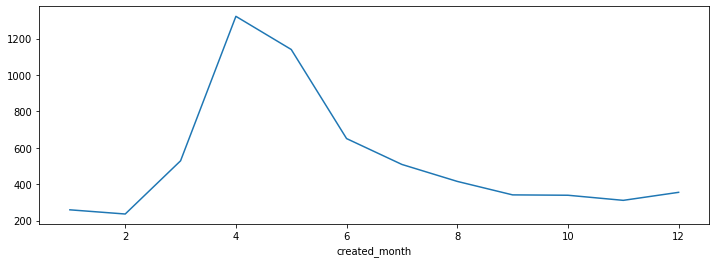

In [61]:
df.loc[df["posts_by_user"]=='2'].groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

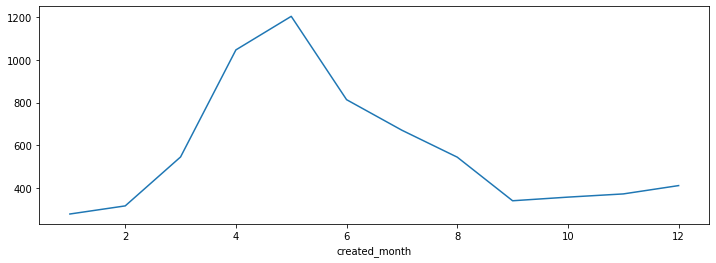

In [68]:
df.loc[df["posts_by_user"]=='6-10'].groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

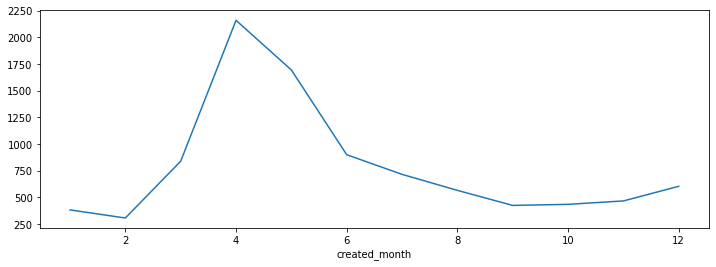

In [75]:
df.loc[df["posts_by_user"]=='1'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

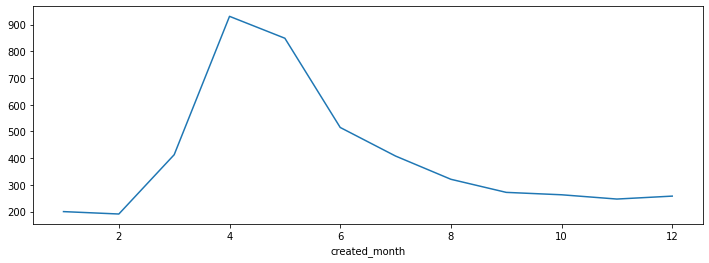

In [74]:
df.loc[df["posts_by_user"]=='2'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

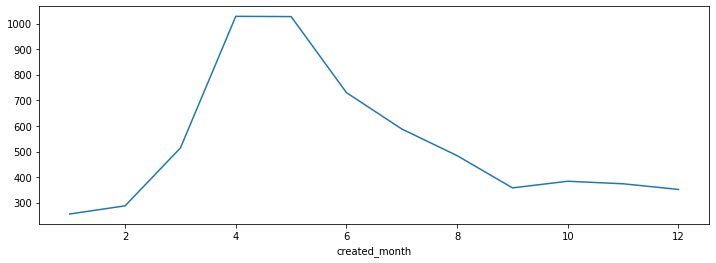

In [73]:
df.loc[df["posts_by_user"]=='3-5'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

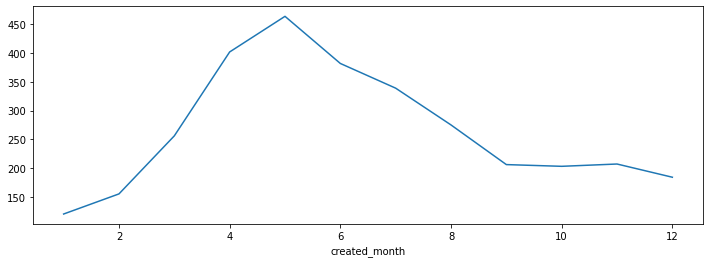

In [71]:
df.loc[df["posts_by_user"]=='6-10'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

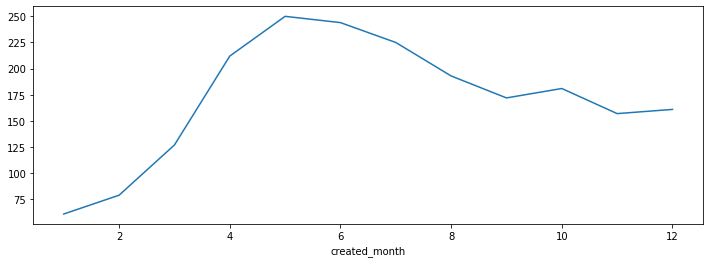

In [70]:
df.loc[df["posts_by_user"]=='11-50'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

<AxesSubplot:xlabel='created_month'>

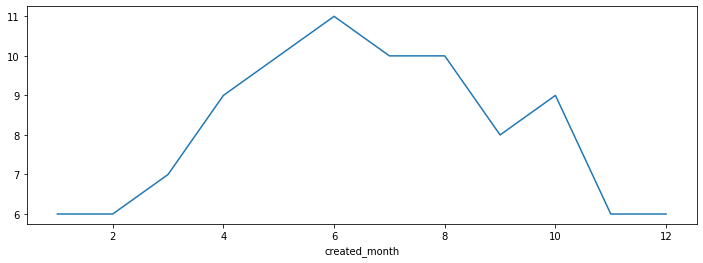

In [72]:
df.loc[df["posts_by_user"]=='Over 50'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

In [69]:
df.loc[df["posts_by_user"]=='Over 50']

,Unnamed: 0,id,score,created_utc,title,num_comments,author,posts_by_user,created,created_month,created_month_label,created_short,created_weekday,created_hour,created_week
131,40,eip33x,1,1577918902,Not my video but so satisfying!,0,Pmcdonald16,Over 50,2020-01-01 22:48:22,1,January,2020-01-01,2,22,1
132,150,ejwwmd,7,1578146206,Why does my sourdough bread (2nd ever loaf) no...,8,Pmcdonald16,Over 50,2020-01-04 13:56:46,1,January,2020-01-04,5,13,1
133,151,ejwzhs,8,1578146686,Why is my sourdough doing this?,22,Pmcdonald16,Over 50,2020-01-04 14:04:46,1,January,2020-01-04,5,14,1
134,927,eqyasg,1,1579450887,Good name for my starter🤔,1,Pmcdonald16,Over 50,2020-01-19 16:21:27,1,January,2020-01-19,6,16,3
135,1209,etgzkc,1,1579901605,Could I just use my mature sourdough starter i...,1,Pmcdonald16,Over 50,2020-01-24 21:33:25,1,January,2020-01-24,4,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30115,39599,kagp9s,1,1607612294,Seeded sourdough baguette,0,Breadtales,Over 50,2020-12-10 14:58:14,12,December,2020-12-10,3,14,50
30116,39803,kcacx6,1,1607865040,"100% whole grain boule (spelt+wheat), no knead...",7,Breadtales,Over 50,2020-12-13 13:10:40,12,December,2020-12-13,6,13,50
30117,40124,kf0bkf,2,1608221649,"100% whole grain loaf (50% spelt, 50% wheat).....",2,Breadtales,Over 50,2020-12-17 16:14:09,12,December,2020-12-17,3,16,51
30118,40930,kl4zpk,1,1609081268,No-knead sourdough demi baguettes,4,Breadtales,Over 50,2020-12-27 15:01:08,12,December,2020-12-27,6,15,52


# Text analysis

- [How To Perform Sentiment Analysis in Python 3 Using the Natural Language Toolkit (NLTK)](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)
- [Sentiment Analysis on Reddit News Headlines with Python’s Natural Language Toolkit (NLTK)](https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/)

## Sentiment analysis on title using nltk Vader

In [193]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in titles_lemmatised:
    pol_score = sia.polarity_scores(line)
    pol_score['title'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'neu': 0.655, 'pos': 0.345, 'compound': 0.6997, 'title': 'first attempt starter really hope manage keep alive mixed existence open second decade'}, {'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772, 'title': 'skillet dutch oven sourdough rainy pacific northwest'}, {'neg': 0.07, 'neu': 0.579, 'pos': 0.351, 'compound': 0.7783, 'title': 'last bread 2019 use brad claire recipe alive sourdough starter smell bit sweet weird bread turn good anyways'}]


In [194]:
new_df = pd.DataFrame.from_records(results)

new_df['label'] = 0
new_df.loc[new_df['compound'] > 0.2, 'label'] = 1
new_df.loc[new_df['compound'] < -0.2, 'label'] = -1
new_df.head()

,neg,neu,pos,compound,title,label
0,0.000,0.655,0.345,0.6997,first attempt starter really hope manage keep ...,1
1,0.178,0.822,0.000,-0.0772,skillet dutch oven sourdough rainy pacific nor...,0
2,0.070,0.579,0.351,0.7783,last bread 2019 use brad claire recipe alive s...,1
3,0.333,0.667,0.000,-0.7181,start bake september never happy decision may ...,-1
4,0.000,1.000,0.000,0.0000,sourdough book,0


In [195]:
df2 = new_df[['title', 'label']]

print(df2["label"].value_counts())
print(df2["label"].value_counts(normalize=True) * 100)

 0    20029
 1    17308
-1     3972
Name: label, dtype: int64
 0    48.485802
 1    41.898860
-1     9.615338
Name: label, dtype: float64


In [75]:
pd.DataFrame(df2.loc[df2["label"]== -1, "title"]).to_csv(".//data/processed/negative_title.csv")

In [196]:
df2.loc[df2["label"]== 1]

,title,label
0,first attempt starter really hope manage keep ...,1
2,last bread 2019 use brad claire recipe alive s...,1
10,sourdough starter smell like vomit,1
14,happy turn,1
15,third attempt much happy result,1
...,...,...
41299,right mr demille -PRON- be ready closeup,1
41301,happy new year,1
41302,lot fun improve score skill 😊 😊,1
41305,happy sourdough finally turn month dense pale ...,1


#### most frequent words

In [147]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(example)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_text(titles):
    tokens = []
    for line in titles:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [197]:
title_tokens = process_text(df2["title"])
word_freq = nltk.FreqDist(title_tokens)

word_freq.most_common(100)

[('sourdough', 12047),
 ('loaf', 8432),
 ('first', 7994),
 ('starter', 6434),
 ('bread', 4522),
 ('make', 4337),
 ('get', 3781),
 ('pron', 2926),
 ('bake', 2909),
 ('flour', 2749),
 ('good', 2696),
 ('attempt', 2620),
 ('time', 2606),
 ('crumb', 2518),
 ('oven', 2445),
 ('use', 2080),
 ('recipe', 1946),
 ('hydration', 1895),
 ('finally', 1857),
 ('try', 1825),
 ('one', 1739),
 ('day', 1698),
 ('happy', 1675),
 ('dough', 1642),
 ('well', 1632),
 ('help', 1568),
 ('like', 1494),
 ('go', 1449),
 ('look', 1386),
 ('rise', 1373),
 ('today', 1347),
 ('wheat', 1343),
 ('whole', 1282),
 ('ever', 1227),
 ('second', 1215),
 ('ear', 1184),
 ('still', 1179),
 ('think', 1156),
 ('start', 1140),
 ('rye', 1125),
 ('discard', 1085),
 ('score', 1021),
 ('turn', 1012),
 ('new', 985),
 ('pretty', 959),
 ('week', 904),
 ('little', 883),
 ('need', 877),
 ('dutch', 847),
 ('yet', 822),
 ('pizza', 819),
 ('hour', 818),
 ('much', 818),
 ('taste', 818),
 ('spring', 813),
 ('work', 811),
 ('tip', 807),
 ('great

#### most frequent positive words

In [198]:
pos_lines = list(df2.loc[df2["label"] == 1, "title"])

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('sourdough', 4966),
 ('loaf', 4563),
 ('first', 3974),
 ('starter', 2639),
 ('good', 2452),
 ('make', 2278),
 ('bread', 2145),
 ('get', 2074),
 ('pron', 1956),
 ('happy', 1585),
 ('crumb', 1477),
 ('well', 1461),
 ('bake', 1435),
 ('time', 1428),
 ('help', 1359),
 ('attempt', 1347),
 ('like', 1292),
 ('flour', 1249),
 ('oven', 1244),
 ('one', 1153)]

#### most frequent negative words

In [151]:
neg_lines = list(df2.loc[df2["label"] == -1, "title"])

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('sourdough', 933),
 ('starter', 807),
 ('discard', 608),
 ('first', 583),
 ('loaf', 530),
 ('bread', 370),
 ('wrong', 342),
 ('bad', 240),
 ('oven', 234),
 ('made', 212),
 ('time', 194),
 ('dough', 191),
 ('flour', 189),
 ('attempt', 158),
 ('crumb', 148),
 ('recipe', 143),
 ('hydration', 132),
 ('finally', 123),
 ('day', 118),
 ('got', 117)]

In [199]:
neg_lines = list(df2.loc[df2["label"] == -1, "title"])

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('sourdough', 980),
 ('starter', 835),
 ('first', 634),
 ('discard', 616),
 ('loaf', 588),
 ('make', 419),
 ('bread', 410),
 ('get', 359),
 ('wrong', 341),
 ('go', 282),
 ('pron', 272),
 ('bad', 254),
 ('bake', 244),
 ('oven', 242),
 ('use', 233),
 ('time', 232),
 ('crumb', 221),
 ('attempt', 210),
 ('dough', 210),
 ('flour', 209)]

In [200]:
df2.loc[df2["label"] == 1, "title"]

0        first attempt starter really hope manage keep ...
2        last bread 2019 use brad claire recipe alive s...
10                      sourdough starter smell like vomit
14                                              happy turn
15                         third attempt much happy result
                               ...                        
41299             right mr demille -PRON- be ready closeup
41301                                       happy new year
41302                      lot fun improve score skill 😊 😊
41305    happy sourdough finally turn month dense pale ...
41307    get first starter last week christmas present ...
Name: title, Length: 17308, dtype: object

## Topic analysis